#### Purpose of this notebook
- To estimate the causal effect of preventive healthcare access on diabetes prevalence in Georgia explicitly addressing selection bias and confounding using modern causal inference methods.
We aim to estimate the Average Treatment Effect (ATE) and Heterogeneous Treatment Effects (HTE) of preventive healthcare access on diabetes prevalence.

- Formaly;

- 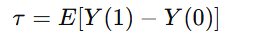

Where:
𝑌(1): diabetes prevalence with high preventive care access

Y(0): diabetes prevalence with low preventive care access

#### Defining Treatment and Control

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# Load your prepared data
df = pd.read_csv("brfss_diabetes_cleaned.csv")
df.head(2)

,Year,Locationabbr,Locationdesc,Topic,Question,Break_Out_Category,Break_Out,Sample_Size,Data_value,Question_Role,Variable_Name
0,2024,GA,Georgia,Diabetes,Have you ever been told by a doctor that you h...,Overall,Overall,"1,242",12.8,Outcome (Diabetes),diabetes_status
1,2024,GA,Georgia,Diabetes,Have you ever been told by a doctor that you h...,Overall,Overall,46,0.6,Outcome (Diabetes),diabetes_status


#### Treatment definition

In [5]:
# Define survey questions
diabetes_q = "Have you ever been told by a doctor that you have diabetes?"
checkup_q = "About how long has it been since you last visited a doctor for a routine checkup?"

# Filter outcome (diabetes) and prevention (checkup) data
df_d = df.query("Question == @diabetes_q").copy()
df_c = df.query("Question == @checkup_q").copy()

# Define merge keys
merge_keys = ["Year", "Break_Out_Category", "Break_Out"]

# Merge outcome and prevention datasets
df_ca = pd.merge(
    df_d,
    df_c,
    on=merge_keys,
    suffixes=("_diabetes", "_checkup")
)

# Inspect merged dataset
print("Shape of merged DataFrame:", df_ca.shape)
print(df_ca.head(2))


Shape of merged DataFrame: (9375, 19)
   Year Locationabbr_diabetes Locationdesc_diabetes Topic_diabetes  \
0  2024                    GA               Georgia       Diabetes   
1  2024                    GA               Georgia       Diabetes   

                                   Question_diabetes Break_Out_Category  \
0  Have you ever been told by a doctor that you h...            Overall   
1  Have you ever been told by a doctor that you h...            Overall   

  Break_Out Sample_Size_diabetes  Data_value_diabetes Question_Role_diabetes  \
0   Overall                1,242                 12.8     Outcome (Diabetes)   
1   Overall                1,242                 12.8     Outcome (Diabetes)   

  Variable_Name_diabetes Locationabbr_checkup Locationdesc_checkup  \
0        diabetes_status                   GA              Georgia   
1        diabetes_status                   GA              Georgia   

  Topic_checkup                                   Question_checkup  \
0  

#### diabetes prevalence and preventive checkup access compare across categories

In [7]:
# Summarize average diabetes prevalence and checkup access by category and subgroup
summary = (
    df_ca.groupby(["Break_Out_Category", "Break_Out"])
    .agg(
        avg_diabetes=("Data_value_diabetes", "mean"),
        avg_checkup=("Data_value_checkup", "mean"),
        count=("Year", "count")
    )
    .reset_index()
    .sort_values(["Break_Out_Category", "Break_Out"])
)

print(summary.head(10))  # preview first 10 rows


   Break_Out_Category         Break_Out  avg_diabetes  avg_checkup  count
0           Age Group             18-24     96.631098    27.254878    164
1           Age Group             25-34     61.277739    25.053357    283
2           Age Group             35-44     42.624311    25.793484    399
3           Age Group             45-54     39.162683    26.997561    410
4           Age Group             55-64     34.916355    29.578271    428
5           Age Group               65+     36.554491    35.117066    334
6  Education Attained  College graduate     33.334766    26.641016    512
7  Education Attained    H.S. or G.E.D.     34.264522    23.772696    575
8  Education Attained    Less than H.S.     42.656430    25.619685    381
9  Education Attained    Some post-H.S.     33.929264    25.855233    516


#### Binary treatment Indicator

In [8]:
# Define threshold for high vs low preventive care access (median split)
threshold = df_ca["Data_value_checkup"].median()
print("Median threshold for preventive care access:", threshold)

# Create treatment indicator: 1 = high access, 0 = low access
df_ca["treated"] = (df_ca["Data_value_checkup"] >= threshold).astype(int)

# Show counts of high vs low access groups
print("\nDistribution of preventive care access groups:")
print(df_ca["treated"].value_counts())


Median threshold for preventive care access: 10.9

Distribution of preventive care access groups:
treated
1    4720
0    4655
Name: count, dtype: int64


#### Confounder Set

In [9]:
confounders = [
    "C(Break_Out)",
    "C(Break_Out_Category)",
    "C(Year)"
]

#### Estimate propensity scores

In [13]:
import statsmodels.formula.api as smf
# Define categorical confounders for regression models
confounders = [
    "C(Break_Out)",          # subgroup (e.g., income, education, race/ethnicity)
    "C(Break_Out_Category)", # category type
    "C(Year)"                # year fixed effects
]

# Example: build a regression formula dynamically
formula = "Data_value_diabetes ~ Data_value_checkup + " + " + ".join(confounders)

print("Regression formula:", formula)

# Fit the model
model_conf = smf.ols(
    formula=formula,
    data=df_ca
).fit(cov_type="HC3")

print(model_conf.summary())


Regression formula: Data_value_diabetes ~ Data_value_checkup + C(Break_Out) + C(Break_Out_Category) + C(Year)
                             OLS Regression Results                            
Dep. Variable:     Data_value_diabetes   R-squared:                       0.102
Model:                             OLS   Adj. R-squared:                  0.098
Method:                  Least Squares   F-statistic:                     4857.
Date:                 Thu, 25 Dec 2025   Prob (F-statistic):               0.00
Time:                         18:17:51   Log-Likelihood:                -46773.
No. Observations:                 9375   AIC:                         9.363e+04
Df Residuals:                     9334   BIC:                         9.392e+04
Df Model:                           40                                         
Covariance Type:                   HC3                                         
                                                                              coef    std 

C:\Users\brian\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 45, but rank is 41
  warnings.warn('covariance of constraints does not have full '


##### Interpretation.
When controlling simultaneously for demographic composition, socioeconomic characteristics and year fixed effects, preventive healthcare access is no longer associated with diabetes prevalence. This indicates that earlier associations were driven by compositional differences and secular trends rather than a direct effect of prevention. The dominance of age, education, race, and time effects highlights the chronic and cumulative nature of diabetes risk.

In [29]:
from sklearn.preprocessing import StandardScaler
# Suppose you have continuous predictors in df_ca
continuous_vars = ["Data_value_checkup", "Data_value_diabetes"]

# Normalize continuous predictors
scaler = StandardScaler()
df_ca[continuous_vars] = scaler.fit_transform(df_ca[continuous_vars])

# Build design matrix with categorical + normalized continuous predictors
X = pd.get_dummies(df_ca[["Break_Out", "Break_Out_Category", "Year"]], drop_first=True)
X[continuous_vars] = df_ca[continuous_vars]  # add normalized continuous vars
y = df_ca["treated"]

# Fit logistic regression (scikit-learn for robustness)
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000, solver="lbfgs")
clf.fit(X, y)

# Save propensity scores
df_ca["pscore"] = clf.predict_proba(X)[:, 1]

print("Propensity score range:", df_ca["pscore"].min(), "to", df_ca["pscore"].max())
print(df_ca[["treated", "pscore"]].head())


Propensity score range: 1.8098495735844253e-05 to 1.0
   treated    pscore
0        1  1.000000
1        0  0.335573
2        0  0.019498
3        0  0.003930
4        0  0.000088


#### Overlap diagnostics

In [30]:
#Check balance predictors
print(df_ca["treated"].value_counts())
print(df_ca.groupby("Break_Out")["treated"].value_counts())

treated
1    4720
0    4655
Name: count, dtype: int64
Break_Out                                                treated
$100,000-$199,999                                        0           51
                                                         1           38
$15,000-$24,999                                          1          228
                                                         0          163
$200,000+                                                1           20
                                                         0           13
$25,000-$34,999                                          1          169
                                                         0          128
$35,000-$49,999                                          0          160
                                                         1          158
$50,000+                                                 0          188
                                                         1          156
$50,000-$99,999  

#### Plot KDE to check overlap

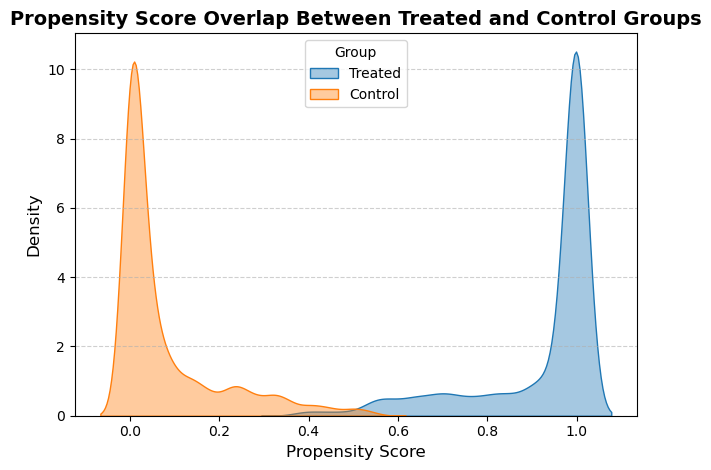

In [37]:
# Treated group
sns.kdeplot(
    df_ca.loc[df_ca["treated"] == 1, "pscore"],
    label="Treated",
    fill=True,
    alpha=0.4,
    color="tab:blue"
)

# Control group
sns.kdeplot(
    df_ca.loc[df_ca["treated"] == 0, "pscore"],
    label="Control",
    fill=True,
    alpha=0.4,
    color="tab:orange"
)

plt.title("Propensity Score Overlap Between Treated and Control Groups", fontsize=14, weight="bold")
plt.xlabel("Propensity Score", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(title="Group")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

##### Overlap Diagnostics.
Propensity score distributions reveal substantial separation between treated and control groups indicating limited common support. This suggests that high preventive healthcare access is highly predictable from observed covariates and that a binary treatment contrast is not well supported by the data. As a result, standard inverse probability weighting estimators are unlikely to yield credible average treatment effect estimates. These findings motivate a shift toward local or continuous treatment effect estimation and machine-learning–based approaches to heterogeneity.

#### Plot the histogram sisde by side

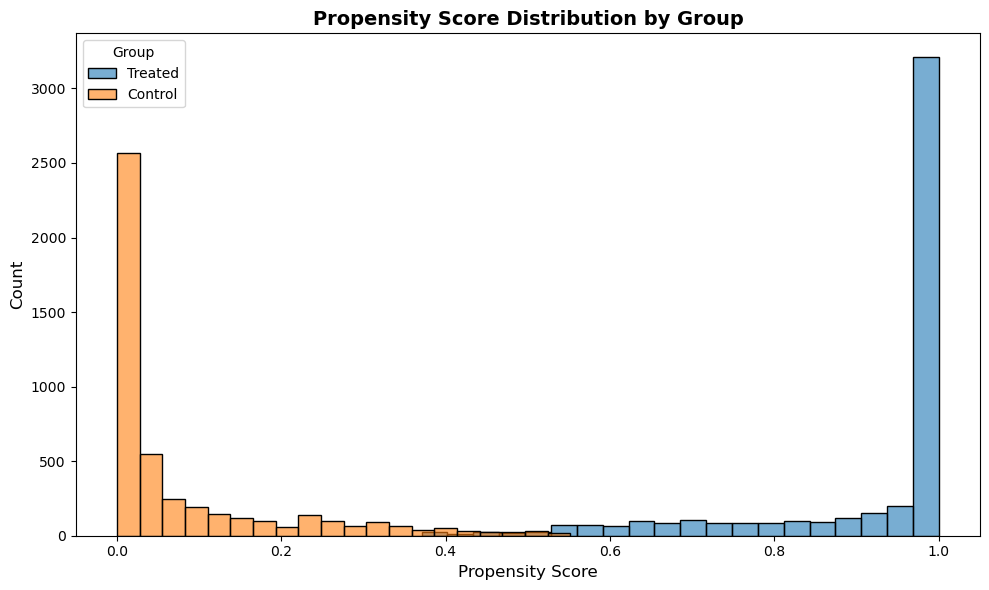

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(df_ca.loc[df_ca["treated"] == 1, "pscore"], color="tab:blue", label="Treated", bins=20, alpha=0.6)
sns.histplot(df_ca.loc[df_ca["treated"] == 0, "pscore"], color="tab:orange", label="Control", bins=20, alpha=0.6)

plt.title("Propensity Score Distribution by Group", fontsize=14, weight="bold")
plt.xlabel("Propensity Score", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title="Group")
plt.tight_layout()
plt.show()

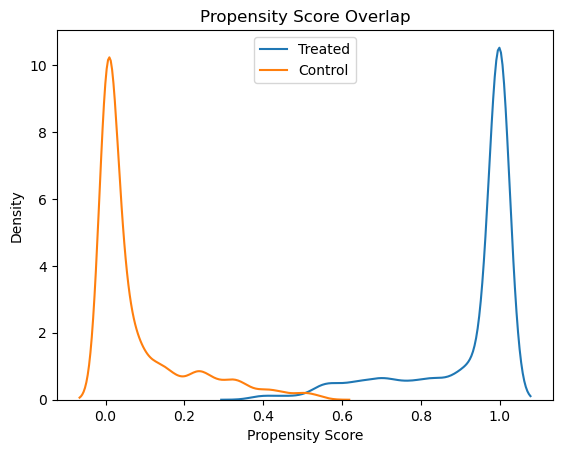

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(df_ca[df_ca["treated"] == 1]["pscore"], label="Treated")
sns.kdeplot(df_ca[df_ca["treated"] == 0]["pscore"], label="Control")
plt.title("Propensity Score Overlap")
plt.xlabel("Propensity Score")
plt.legend()
plt.show()

#### Note
Due to strong selection into preventive care and limited overlap between treated and control groups, the data do not support credible estimation of a global average causal effect of preventive healthcare access on diabetes prevalence. we shall focus on identifying high-risk subpopulations for targeted prevention strategies.